In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import sys, os
sys.path.append('/Users/roz18/git/Python/user_modules')
from readEazyBinary import readpz
import scipy.interpolate
import scipy.integrate
import scipy

In [2]:
def compute_cdf(a, bins):
    """
    Inputs
    ------
    a: 1-D array of elements;
    bins: bins for the CDF;

    Outputs
    -------
    cdf: 1-D array of CDF values in each bin; 
    binedges: edges of the bins;
    binctr: center of the bins;
    """
    hist, binedges = np.histogram(a, bins=bins)
    hist = hist/len(a)
    binctr = (binedges[1:] + binedges[:-1])/2.
    cdf = np.zeros(len(hist))
    cdf[0] = hist[0]
    for cdf_index in range(1, len(hist)):
        cdf[cdf_index] = cdf[cdf_index-1]+hist[cdf_index]
        
    return cdf, binedges, binctr

In [3]:
path = '/Users/roz18/Dropbox/Work/mini-projects/Buzzard-EAZY/inputs_Buzzard_training/OUTPUT'

cat = Table.read('/Users/roz18/Documents/Data/mini-projects/buzzard_photo-z/Final_Buzzard_training_file.fits')
print(len(cat))

# Gold sample cut
mask = cat['LSSTi']<25.3
print(np.sum(mask))

# Remove objects with invalide flux measurements
mask = mask & (cat['LSSTu']!=99.) & (cat['LSSTg']!=99.) & (cat['LSSTr']!=99.) & \
       (cat['LSSTi']!=99.) & (cat['LSSTz']!=99.) & (cat['LSSTy']!=99.)
print(np.sum(mask))

# redshift range
zmin = 0.
zmax = 2.0
mask = mask & (cat['redshift']>zmin) & (cat['redshift']<zmax)
print(np.sum(mask))
cat = cat[mask]
z_spec = cat['redshift']

111171
44410
43486
43486


In [4]:
# Load p(z) data
pz_dict = readpz(MAIN_OUTPUT_FILE='photz', OUTPUT_DIRECTORY=path, APPLY_PRIOR=False)
# Redshift grid
zgrid = pz_dict['zgrid']
# p(z)
pz = pz_dict['pz'][mask]
# prior = pz_dict['prior'][mask]
# chi squared
chi2 = pz_dict['chi2'][mask]

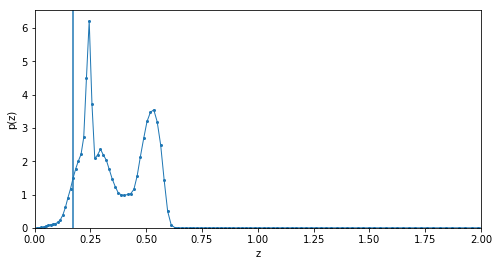

In [8]:
idx = 358
plt.figure(figsize=(8, 4))
plt.plot(zgrid, pz[idx], '.-', markersize=4, lw=1)
# plt.plot(zgrid, prior[idx])
plt.axvline(z_spec[idx])
plt.xlim(0, 2.)
plt.ylim(ymin=0)
plt.xlabel('z')
plt.ylabel('p(z)')
plt.show()

In [9]:
len(pz)

43486

In [14]:
np.savetxt?

In [30]:
size = 100
np.random.seed(1842)
idx = np.random.choice(len(pz), size=size, replace=False)
np.savetxt('/Users/roz18/Documents/git/PZDC1paper/mystuff/pz.txt', pz[idx])
np.savetxt('/Users/roz18/Documents/git/PZDC1paper/mystuff/zgrid.txt', zgrid)
np.savetxt('/Users/roz18/Documents/git/PZDC1paper/mystuff/zspec.txt', z_spec[idx])

------------

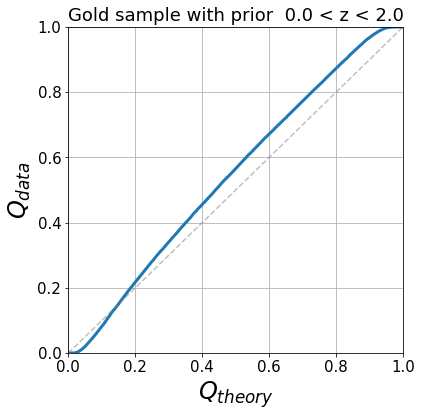

In [23]:
zgrid1 = np.ones((len(pz), len(zgrid)))*zgrid
t = np.array(zgrid1 < np.array(z_spec)[:, None], dtype=float)
# set p(z) to zero for z>z_spec
pz1 = pz * t
# Integrate to get CDF values at z_spec
cdfs = np.trapz(pz1, zgrid, axis=1)
# Sort CDF values to get quantiles
q_data = np.sort(cdfs)
q_theory = np.linspace(0.5/len(q_data), 1-0.5/len(q_data), len(q_data))

x = np.linspace(0, 1)
plt.figure(figsize=(6,6))
plt.plot(q_theory, q_data, linewidth=3)
plt.plot(x, x, '--', color='grey', alpha=0.5)
plt.title('Gold sample with prior  {} < z < {}'.format(zmin, zmax), fontsize=18)
plt.xlabel(r'$Q_{theory}$', fontsize=24)
plt.ylabel(r'$Q_{data}$', fontsize=24)
plt.tick_params(labelsize=15)
plt.axis([0, 1., 0, 1.])
plt.grid()
plt.show()

__The above QQ plot is the inverse function of the CDF of the CDF values:__

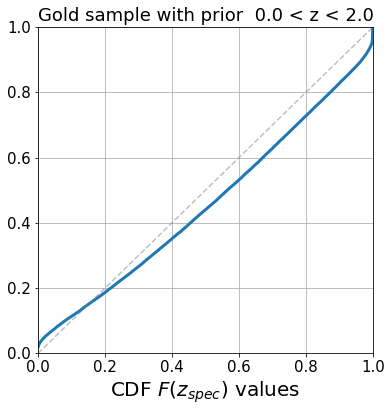

In [24]:
bins = np.linspace(0, 1, int(1e3))
cdf, _, binctr = compute_cdf(cdfs, bins=bins)

x = np.linspace(0, 1)

plt.figure(figsize=(6,6))
plt.plot(binctr, cdf, linewidth=3)
plt.plot(x, x, '--', color='grey', alpha=0.5)
plt.title('Gold sample with prior  {} < z < {}'.format(zmin, zmax), fontsize=18)
plt.xlabel(r'CDF $F(z_{spec})$ values', fontsize=20)
# plt.ylabel(r'$$', fontsize=24)
plt.tick_params(labelsize=15)
plt.axis([0, 1., 0, 1.])
plt.grid()
plt.show()

## Interpolate p(z)

In [25]:
# Insert points between the grid points
# set the number of iterations
n_iterations = 3
zgrid_fine = zgrid.copy()
for index in range(n_iterations):
    zgrid1 = np.zeros(len(zgrid_fine)*2-1)
    zgrid1[::2] = zgrid_fine
    zgrid1[1::2] = (zgrid_fine[:-1]+zgrid_fine[1:])/2
    zgrid_fine = zgrid1.copy()
    
pz_fine = np.zeros((len(pz), len(zgrid_fine)))
for index in range(len(pz)):
    pz_interp = scipy.interpolate.interp1d(zgrid, pz[index], kind='linear')
    pz_fine[index] = pz_interp(zgrid_fine)
    print('\r{}'.format(index), end='')

43485

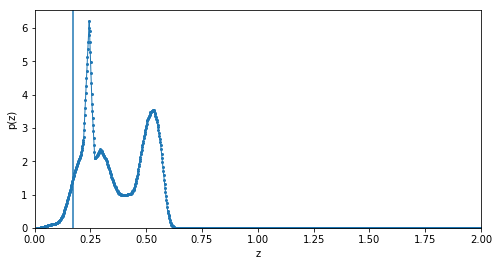

In [26]:
idx = 358
plt.figure(figsize=(8, 4))
plt.plot(zgrid_fine, pz_fine[idx], '.-', markersize=4, lw=1)
# plt.plot(zgrid, prior[idx])
plt.axvline(z_spec[idx])
plt.xlim(0, 2.)
plt.ylim(ymin=0)
plt.xlabel('z')
plt.ylabel('p(z)')
plt.show()

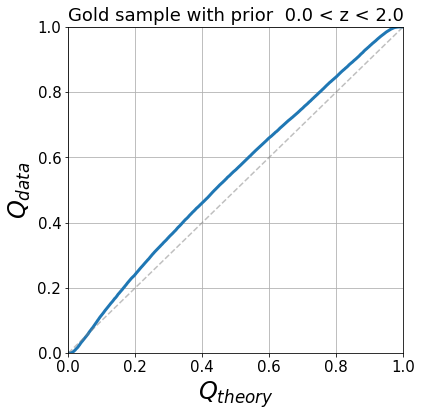

In [27]:
zgrid1 = np.ones((len(pz_fine), len(zgrid_fine)))*zgrid_fine
t = np.array(zgrid1< z_spec[:, None], dtype=float)
# set p(z) to zero for z>z_spec
pz1 = pz_fine * t
# Integrate to get CDF values at z_spec
cdfs = np.trapz(pz1, zgrid_fine, axis=1)
# Sort CDF values to get quantiles
q_data = np.sort(cdfs)
q_theory = np.linspace(0.5/len(q_data), 1-0.5/len(q_data), len(q_data))

x = np.linspace(0, 1)
plt.figure(figsize=(6,6))
plt.plot(q_theory, q_data, linewidth=3)
plt.plot(x, x, '--', color='grey', alpha=0.5)
plt.title('Gold sample with prior  {} < z < {}'.format(zmin, zmax), fontsize=18)
plt.xlabel(r'$Q_{theory}$', fontsize=24)
plt.ylabel(r'$Q_{data}$', fontsize=24)
plt.tick_params(labelsize=15)
plt.axis([0, 1., 0, 1.])
plt.grid()
plt.show()

In [28]:
np.savetxt('/Users/roz18/Documents/git/PZDC1paper/mystuff/zgrid_fine.txt', zgrid_fine)
np.savetxt('/Users/roz18/Documents/git/PZDC1paper/mystuff/pz_fine.txt', pz_fine[idx])